In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
import scipy as sp

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

import lightgbm as lgb
import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

In [4]:
class MeanTargetEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_columns, target_name, alpha=100):
        self.cat_columns = cat_columns
        self.target_name = target_name
        self.mean_encodings = {}
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.global_mean = X[self.target_name].mean()
        
        def smoothing(x):
            return (x.mean() * len(x) + self.global_mean * self.alpha) / (len(x) + self.alpha)    

        for col in self.cat_columns:
            self.mean_encodings[col] = X.groupby(col)[self.target_name].apply(smoothing)
            
    def predict(self, X):
        X_new = np.zeros(shape=(len(X), len(self.cat_columns)))

        for index, col in enumerate(self.cat_columns):    
            X_new[:, index] = X.loc[:, col].map(self.mean_encodings[col]).fillna(self.global_mean).values

        return X_new

In [5]:
TRAIN_PATH     = os.path.join(basepath, 'data/processed/train_text.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test_text.feather')
INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission21.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev6/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev6/val.feather')
# INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission21_val.feather')

In [6]:
%%time

train  = pd.read_feather(f'{TRAIN_PATH}')
test   = pd.read_feather(f'{TEST_PATH}')

CPU times: user 679 ms, sys: 384 ms, total: 1.06 s
Wall time: 3.98 s


In [7]:
%%time

# first keyword of the subject
train.loc[:, 'first_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'first_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0])).str.replace(r'September|July|October|November|December', 'month')

CPU times: user 6.38 s, sys: 57.9 ms, total: 6.44 s
Wall time: 6.44 s


## Feature Engineering

In [8]:
%%time

# is_click
mte_click         = MeanTargetEncoding(['user_id'], target_name='is_click')
mte_click_encoded = cross_val_predict(mte_click, train, y=train.is_click, cv=5, n_jobs=-1)

user_click_mte = pd.DataFrame(mte_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# is_open
mte_open         = MeanTargetEncoding(['user_id'], target_name='is_open')
mte_open_encoded = cross_val_predict(mte_open, train, y=train.is_open, cv=5, n_jobs=-1)

user_open_mte = pd.DataFrame(mte_open_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# generate for test
mte_click.fit(train, train.is_click)
mte_click_test_encoded = mte_click.predict(test)

mte_open.fit(train, train.is_open)
mte_open_test_encoded = mte_open.predict(test)

user_click_test =  pd.DataFrame(mte_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

user_open_test =  pd.DataFrame(mte_open_test_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

train = pd.concat((train, user_click_mte, user_open_mte), axis=1)
test  = pd.concat((test, user_click_test, user_open_test), axis=1)

CPU times: user 54.3 s, sys: 3.71 s, total: 58 s
Wall time: 2min 17s


In [9]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

In [10]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]

def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)
    
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

user_age = traintest.groupby('user_id').apply(lambda x: (x['send_date'].max() - x['send_date'].min()).days)
traintest.loc[:, 'user_age'] = traintest.user_id.map(user_age)

CPU times: user 8min 28s, sys: 3.48 s, total: 8min 32s
Wall time: 8min 31s


In [11]:
%%time

traintest.index = np.arange(len(traintest))
traintest.to_feather(f'{INTERIM_PATH}')

CPU times: user 692 ms, sys: 425 ms, total: 1.12 s
Wall time: 1.83 s


In [12]:
%%time

# number of digits in the subject line.
digit_pattern      = re.compile(r'\d+')
traintest.loc[:, 'subject_num_digits'] = traintest.subject.map(lambda x: len(re.findall(digit_pattern, x)))

# whether subject line has punctuation or not.
punctuation_pattern = re.compile(r'[!.?\-",]+')
traintest.loc[:, 'subject_has_punctuation'] = traintest.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

# interaction between open rate and click rate.
traintest.loc[:, 'click_to_open']      = traintest.loc[:, 'user_id_click_mte_mean'] / traintest.loc[:, 'user_id_open_mte_mean']

# Number of keywords in subject.
traintest.loc[:, 'num_keywords']       = traintest.subject.map(lambda x: len(x.split(' ')))

# Number of short keywords in subject.
traintest.loc[:, 'num_short_keywords'] = traintest.subject.map(lambda x: len(list(filter(lambda x: len(x) > 4, x.split()))))

# Ratio of short to total keywords.
traintest.loc[:, 'ratio_short_total']  = traintest.num_short_keywords / traintest.num_keywords

# Total number of characters in the subject.
traintest.loc[:, 'num_characters']     = traintest.subject.map(lambda x: len(x))

# Number of times first keyword was used in the past
traintest.loc[:, 'first_keyword_count'] = traintest.groupby('first_keyword')['first_keyword'].transform(lambda x: len(x))

CPU times: user 26.6 s, sys: 1.8 s, total: 28.4 s
Wall time: 28.6 s
Parser   : 131 ms


In [13]:
FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent', 'num_diff_email_types', 
            'most_sent_type', 'diff_hour', 'avg_diff_send_date',
            'user_id_click_mte_mean', 'user_id_open_mte_mean',
            'user_age','subject_num_digits', 'subject_has_punctuation',
            'click_to_open', 'num_keywords', 'num_short_keywords',
            'ratio_short_total', 'num_characters',
            'first_keyword_count'
           ]

In [14]:
traintest.loc[:, FEATURES].isnull().sum()

communication_type         0
send_day                   0
send_hour                  0
send_weekday               0
total_links                0
no_of_internal_links       0
no_of_images               0
no_of_sections             0
num_emails_sent            0
num_diff_email_types       0
most_sent_type             0
diff_hour                  0
avg_diff_send_date         0
user_id_click_mte_mean     0
user_id_open_mte_mean      0
user_age                   0
subject_num_digits         0
subject_has_punctuation    0
click_to_open              0
num_keywords               0
num_short_keywords         0
ratio_short_total          0
num_characters             0
first_keyword_count        0
dtype: int64

In [15]:
len(traintest), ntrain

(1797049, 1023191)

In [16]:
X_trn = traintest.iloc[:ntrain].loc[:, FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click'].values

X_val = traintest.iloc[ntrain:].loc[:, FEATURES]
y_val = traintest.iloc[ntrain:]['is_click'].values

print(X_trn.shape, X_val.shape)

del traintest
gc.collect();

(1023191, 24) (773858, 24)


## Validation

In [39]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 31,
    'num_leaves': 31,
    'feature_fraction': .6,
    'feature_fraction_seed': SEED,
    'bagging_fraction': .6,
    'bagging_fraction_seed': SEED,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.728301	eval's auc: 0.711389
[40]	train's auc: 0.740207	eval's auc: 0.709458
[60]	train's auc: 0.749185	eval's auc: 0.716632
[80]	train's auc: 0.757076	eval's auc: 0.723322
[100]	train's auc: 0.761868	eval's auc: 0.72149
[120]	train's auc: 0.766755	eval's auc: 0.721059
[140]	train's auc: 0.770524	eval's auc: 0.716574
[160]	train's auc: 0.774083	eval's auc: 0.715354
Early stopping, best iteration is:
[76]	train's auc: 0.755049	eval's auc: 0.723885


```
[73]	train's auc: 0.752953	eval's auc: 0.715566
[69]	train's auc: 0.752116	eval's auc: 0.716781
```

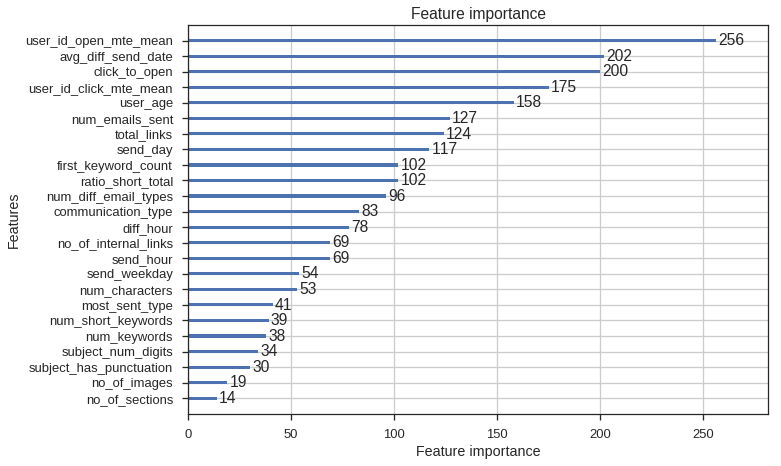

In [40]:
lgb.plot_importance(m);

## Full Training

In [17]:
%%time

params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': (.1 / 1.1),
    'min_data_in_leaf': 31,
    'num_leaves': 31,
    'feature_fraction': .6,
    'feature_fraction_seed': SEED,
    'bagging_fraction': .6,
    'bagging_fraction_seed': SEED,
    'nthread': 4
}

ltrain          = lgb.Dataset(X_trn, y_trn)
num_boost_round = int(76 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

CPU times: user 47.7 s, sys: 610 ms, total: 48.4 s
Wall time: 14.6 s


## Submission

In [18]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission21.csv', index=False)